<a href="https://colab.research.google.com/github/joomj2000/SKT_FLY_AI/blob/main/RNN_LSTM%EA%B3%BC_CNN%EC%9D%98_%EC%A1%B0%ED%95%A9%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%98%81%ED%99%94_%EB%A6%AC%EB%B7%B0_%EB%B6%84%EB%A5%98_%EC%A3%BC%EB%AF%BC%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import imdb
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt



---



## 데이터 읽기

In [71]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7a07d36cfb80>)

In [72]:
# 파일에서 데이터 읽어오기
def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    # 첫 줄은 header 이므로 제외하고 데이터를 처리
    data = []
    for line in lines[1:]:
        # 데이터 형태: id\tdocument\tlabel
        id, document, label = line.strip().split('\t')
        data.append((document, int(label)))

    return data

# 데이터 파일 경로
train_file = 'ratings_train.txt'
test_file = 'ratings_test.txt'

# 데이터 로드
train_data = load_data(train_file)
test_data = load_data(test_file)

# X_train과 y_train으로 분리
X_train = [data[0] for data in train_data]  # train_data에서 문서(document)만 추출
y_train = [data[1] for data in train_data]  # train_data에서 레이블(label)만 추출

# 데이터 확인 (첫 번째 데이터부터 10개만 출력)
print("X_train Example:")
for i in range(10):
    print(X_train[i])

print("\ny_train Example:")
print(y_train[:10])  # 처음 10개의 레이블 출력



# X_train과 y_train으로 분리
X_test = [data[0] for data in test_data]  # train_data에서 문서(document)만 추출
y_test = [data[1] for data in test_data]  # train_data에서 레이블(label)만 추출

# 데이터 확인 (첫 번째 데이터부터 10개만 출력)
print("X_train Example:")
for i in range(10):
    print(X_test[i])

print("\ny_train Example:")
print(y_test[:10])  # 처음 10개의 레이블 출력

X_train Example:
아 더빙.. 진짜 짜증나네요 목소리
흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
너무재밓었다그래서보는것을추천한다
교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
원작의 긴장감을 제대로 살려내지못했다.
별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네
액션이 없는데도 재미 있는 몇안되는 영화
왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?

y_train Example:
[0, 1, 0, 0, 1, 0, 0, 0, 1, 1]
X_train Example:
굳 ㅋ
GDNTOPCLASSINTHECLUB
뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
지루하지는 않은데 완전 막장임... 돈주고 보기에는....
3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
음악이 주가 된, 최고의 음악영화
진정한 쓰레기
마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다
갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다
이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..

y_train Example:
[1, 0, 0, 0, 0, 1, 0, 0, 0, 1]


## 모델 생성 및 학습

In [73]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding



# 정수 인코딩을 위한 Tokenizer 객체 생성
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# 불용어 처리를 위한 추가적인 불용어 목록
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']
tokenizer.word_index = {word:idx for word, idx in tokenizer.word_index.items() if word not in stopwords}

# train 데이터 정수 인코딩 및 패딩
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=10, padding='post')

# test 데이터 정수 인코딩 및 패딩
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=10, padding='post')

# LSTM 모델 구성
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=64, input_length=10),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#학습 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)


# 리스트에서 NumPy 배열로 변환
X_train_pad = np.array(X_train_pad)
y_train = np.array(y_train)


#모델 실행
history = model.fit(X_train_pad, y_train, batch_size=40, epochs=10,
                    validation_split=0.25,
                    callbacks=[early_stopping_callback])




Epoch 1/10
2813/2813 [==============================] - 29s 10ms/step - loss: 0.4381 - accuracy: 0.7812 - val_loss: 0.3912 - val_accuracy: 0.8133
Epoch 2/10
2813/2813 [==============================] - 17s 6ms/step - loss: 0.1501 - accuracy: 0.9461 - val_loss: 0.4861 - val_accuracy: 0.7919
Epoch 3/10
2813/2813 [==============================] - 16s 6ms/step - loss: 0.0668 - accuracy: 0.9778 - val_loss: 0.5650 - val_accuracy: 0.7906
Epoch 4/10
2813/2813 [==============================] - 16s 6ms/step - loss: 0.0369 - accuracy: 0.9878 - val_loss: 0.6499 - val_accuracy: 0.7946
Epoch 5/10
2813/2813 [==============================] - 17s 6ms/step - loss: 0.0236 - accuracy: 0.9915 - val_loss: 0.7691 - val_accuracy: 0.7858
Epoch 6/10
2813/2813 [==============================] - 16s 6ms/step - loss: 0.0180 - accuracy: 0.9932 - val_loss: 0.8487 - val_accuracy: 0.7900


## 결과 평가 및 시각화


Test Accuracy: 0.7844799757003784


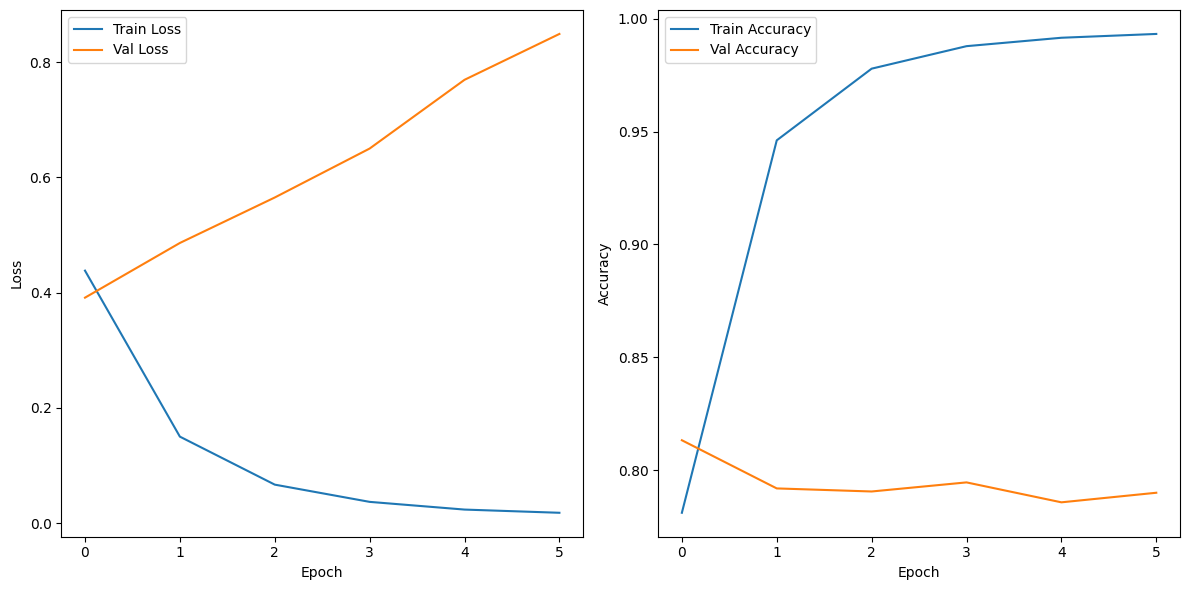

In [74]:
# 모델 평가
y_test = np.array(y_test)
loss, accuracy = model.evaluate(X_test_pad,y_test, verbose=0)
print('Test Accuracy:', accuracy)

# 학습 곡선 그리기
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)